# Train PMF

In [ ]:
from __future__ import print_function

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data

import matplotlib.pyplot as plt

import sys 
sys.path.append('..')

from src.model.pmf import PMF

In [ ]:
def RMSE(preds, truth):
    return np.sqrt(np.mean(np.square(preds-truth)))

In [ ]:
batch_size = 1000
epoches = 1000
no_cuda = False
seed = 1
weight_decay = 0.1
embedding_feature_size = 100
ratio = 0.8
lr = 0.0001
momentum = 0.9

In [ ]:
df = pd.read_csv("../data/ml-100k/ratings.csv")
df["rating"] = df["rating"].astype("float")
df = df.sort_values(["user_id", "timestamp"])
df.head()

In [ ]:
data = df[["user_id", "item_id", "rating"]].values
 
# Normalize rewards to [-1, 1]
data[:,2] = 0.5*(data[:,2] - 3)

# Shuffle data
np.random.shuffle(data)

In [ ]:
# Split data
train_data = data[:int(ratio * data.shape[0])]
vali_data = data[int(ratio * data.shape[0]): int((ratio+(1-ratio)/2)*data.shape[0])]
test_data = data[int((ratio + (1 - ratio) / 2) * data.shape[0]) :]

In [ ]:
NUM_ITEMS = df.item_id.max() + 1
NUM_USERS = df.user_id.max() + 1

print(NUM_USERS, NUM_ITEMS)

In [ ]:
# Get CUDA device if available
cuda = torch.cuda.is_available()
 
# Set device to CUDA or CPU, depending on availability and desire
device = torch.device("cuda" if cuda and no_cuda else "cpu")
 
# Generate and apply seeds
torch.manual_seed(seed=seed)
if cuda:
    torch.cuda.empty_cache()
    torch.cuda.manual_seed(seed=seed)
 
# Specify number of workers for cuda
kwargs = {"num_workers":1, "pin_memory":True} if cuda else {}
 
# Construct Data Loaders
train_data_loader = torch.utils.data.DataLoader(torch.from_numpy(train_data), batch_size=batch_size, shuffle=False, **kwargs)
test_data_loader = torch.utils.data.DataLoader(torch.from_numpy(test_data), batch_size=batch_size, shuffle=False, **kwargs)

In [ ]:
# Initialize model
model = PMF(n_users=NUM_USERS, n_items=NUM_ITEMS, n_factors=embedding_feature_size, no_cuda=no_cuda)
 
# Move model to CUDA if CUDA selected
if cuda:
    model.cuda()
    print("Model moved to CUDA")
 
# Set loss function
loss_function = nn.MSELoss(reduction="sum")

# Set optimizer (uncomment Adam for adam)
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
# optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [ ]:
# Function for training one epoch
def train(epoch, train_data_loader):
    # Initialize
    model.train()
    epoch_loss = 0.0
    optimizer.zero_grad()
 
    # Go through batches
    for batch_idx, ele in enumerate(train_data_loader):
        # Zero optimizer gradient
        optimizer.zero_grad()
 
        # Extract user_id_nums: row 0, item_id_nums: col 1 , ratings: val 2
        row = ele[:, 0]
        col = ele[:, 1]
        val = ele[:, 2]
 
        # Set to variables
        row = Variable(row.long())
        if isinstance(col, list):
            col = tuple(Variable(c.long()) for c in col)
        else:
            col = Variable(col.long())
        val = Variable(val.float())

        # Move data to CUDA
        if cuda:
            row = row.cuda()
            col = col.cuda()
            val = val.cuda()
 
        # Train
        preds = model.forward(row, col)
        loss = loss_function(preds, val)
        loss.backward()
        optimizer.step()
 
        # Update epoch loss
        epoch_loss += loss.data
 
    epoch_loss /= train_data_loader.dataset.shape[0]
    return epoch_loss

In [ ]:
# Training Model

train_loss_list = []
last_vali_rmse = None
train_rmse_list = []
vali_rmse_list = []
print("parameters are: train ratio:{:f},batch_size:{:d}, epoches:{:d}, weight_decay:{:f}".format(ratio, batch_size, epoches, weight_decay))
print(model)

# Go through epochs
for epoch in range(1, epoches+1):
 
    # Train epoch
    train_epoch_loss = train(epoch, train_data_loader)
 
    # Get epoch loss
    train_loss_list.append(train_epoch_loss.cpu())
 
    # Move validation data to CUDA
    if cuda:
        vali_row = Variable(torch.from_numpy(vali_data[:, 0]).long()).cuda()
        vali_col = Variable(torch.from_numpy(vali_data[:, 1]).long()).cuda()
    else:
        vali_row = Variable(torch.from_numpy(vali_data[:, 0]).long())
        vali_col = Variable(torch.from_numpy(vali_data[:, 1]).long())
 
    # Get validation predictions
    vali_preds = model.predict(vali_row, vali_col)
 
    # Calculate train rmse loss
    train_rmse = np.sqrt(train_epoch_loss.cpu())
 
    # Calculate validation rmse loss
    if cuda:
        vali_rmse = RMSE(vali_preds.cpu().data.numpy(), vali_data[:, 2])
    else:
        vali_rmse = RMSE(vali_preds.data.numpy(), vali_data[:, 2])
 
    # Add losses to rmse loss lists
    train_rmse_list.append(train_rmse)
    vali_rmse_list.append(vali_rmse)
 
    print("Training epoch:{: d}, training rmse:{: .6f}, vali rmse:{:.6f}". \
              format(epoch, train_rmse, vali_rmse))
 
    # Early stop condition
    if last_vali_rmse and last_vali_rmse < vali_rmse:
        break
    else:
      last_vali_rmse = vali_rmse
 

In [ ]:
# Testing Model

# Move test set to CUDA
if cuda:
    test_row = Variable(torch.from_numpy(test_data[:, 0]).long()).cuda()
    test_col = Variable(torch.from_numpy(test_data[:, 1]).long()).cuda()
else:
    test_row = Variable(torch.from_numpy(test_data[:, 0]).long())
    test_col = Variable(torch.from_numpy(test_data[:, 1]).long())
 
# Get test predictions
preds = model.predict(test_row, test_col)
 
# Get test rmse loss
if cuda:
    test_rmse = RMSE(preds.cpu().data.numpy(), test_data[:, 2])
else:
    test_rmse = RMSE(preds.data.numpy(), test_data[:, 2])
print("Test rmse: {:f}".format(test_rmse))
 
# Create plots
plt.figure(1)
plt.figure(1).patch.set_facecolor("white")
plt.plot(range(1, len(train_rmse_list)+1), train_rmse_list, color="r", label="train rmse")
plt.plot(range(1, len(vali_rmse_list)+1), vali_rmse_list, color="b", label="test rmse")
plt.legend()
plt.annotate(r"train=%f" % (train_rmse_list[-1]), xy=(len(train_rmse_list), train_rmse_list[-1]),
             xycoords="data", xytext=(-30, 30), textcoords="offset points", fontsize=10,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3, rad=.2"))
plt.annotate(r"vali=%f" % (vali_rmse_list[-1]), xy=(len(vali_rmse_list), vali_rmse_list[-1]),
             xycoords="data", xytext=(-30, 30), textcoords="offset points", fontsize=10,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3, rad=.2"))
plt.xlim([1, len(train_rmse_list)+10])
plt.xlabel("iterations")
plt.ylabel("RMSE")
plt.title("RMSE Curve in Training Process")
plt.show()

In [ ]:
# Save model
path_to_trained_pmf = "../model/pmf/ml_100k_emb_{:d}_ratio_{:f}_bs_{:d}_e_{:d}_wd_{:f}_lr_{:f}_trained_pmf.pt".format(embedding_feature_size, ratio, batch_size, len(train_rmse_list), weight_decay, lr)
torch.save(model.state_dict(), path_to_trained_pmf)

In [ ]:
idx =  0 
model.predict(
    torch.tensor([data[idx][0]]).long().to("cuda"), 
    torch.tensor([data[idx][1]]).long().to("cuda")
).cpu().data[0] * 2 + 3, data[idx][2] * 2 + 3

# Embeddings Analysis

In [1]:
import os
import json
import pickle

import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


import plotly.offline as py
import plotly.express as px
py.init_notebook_mode(connected=True)


import sys 
sys.path.append('..')

from src.model.pmf import PMF

In [2]:
data_version = "movie_lens_100k"
dataset_path = "../data/{}_output_path.json".format(data_version)

with open(dataset_path) as json_file:
    _dataset_path = json.load(json_file)

dataset = {}
with open(os.path.join("..", _dataset_path["train_users_dict"]), "rb") as pkl_file:
    dataset["train_users_dict"] = pickle.load(pkl_file)

with open(os.path.join("..", _dataset_path["train_users_history_lens"]), "rb") as pkl_file:
    dataset["train_users_history_lens"] = pickle.load(pkl_file)

with open(os.path.join("..", _dataset_path["eval_users_dict"]), "rb") as pkl_file:
    dataset["eval_users_dict"] = pickle.load(pkl_file)

with open(os.path.join("..", _dataset_path["eval_users_history_lens"]), "rb") as pkl_file:
    dataset["eval_users_history_lens"] = pickle.load(pkl_file)

with open(os.path.join("..", _dataset_path["users_history_lens"]), "rb") as pkl_file:
    dataset["users_history_lens"] = pickle.load(pkl_file)

with open(os.path.join("..", _dataset_path["item_groups"]), "rb") as pkl_file:
    dataset["item_groups"] = pickle.load(pkl_file)

items_df = pd.read_csv(os.path.join("..", _dataset_path["items_df"]))
items_metadata_df = pd.read_csv(os.path.join("..", _dataset_path["items_metadata"]))
users_df = pd.read_csv(os.path.join("..",_dataset_path["users_df"]))
ratings_df = pd.read_csv(os.path.join("..",_dataset_path["ratings_df"]))


items_df = items_df.set_index("item_id")
items_metadata_df = items_metadata_df.set_index("item_id")
users_df = users_df.set_index("user_id")

In [3]:
def plot_bg(bg_alpha=.01, figsize=(13, 9), emb_2d=None):
    """Create and return a plot of all our movie embeddings with very low opacity.
    (Intended to be used as a basis for further - more prominent - plotting of a 
    subset of movies. Having the overall shape of the map space in the background is
    useful for context.)
    """
    if emb_2d is None:
        emb_2d = embs
    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor("white")
    X = emb_2d[:, 0]
    Y = emb_2d[:, 1]
    ax.scatter(X, Y, alpha=bg_alpha)
    return ax
    
def plot_with_annotations(label_indices, text=True, labels=None, alpha=1, **kwargs):
    ax = plot_bg(**kwargs)
    Xlabeled = embs[label_indices, 0]
    Ylabeled = embs[label_indices, 1]
    if labels is not None:
        for x, y, label in zip(Xlabeled, Ylabeled, labels):
            ax.scatter(x, y, alpha=alpha, label=label, marker='1',
                       s=90,
                      )
        fig.legend()
    else:
        ax.scatter(Xlabeled, Ylabeled, alpha=alpha, color='green')
    
    
    return ax

In [4]:
def single_list_similarity(predicted, feature_df):
    recs_content = feature_df.loc[predicted]
    recs_content = recs_content
    similarity = cosine_similarity(X=recs_content, dense_output=False)

    # #get indicies for upper right triangle w/o diagonal
    upper_right = np.triu_indices(similarity.shape[0], k=1)
    upper_right

    # #calculate average similarity score of all recommended items in list
    ils_single_user = np.mean(similarity[upper_right])
    return ils_single_user

## PMF Embeddings

In [ ]:
import torch

In [ ]:
reward_model = PMF(943, 1682, 100).to("cuda")
reward_model.load_state_dict(
    torch.load(
        "../model/pmf/ml_100k_emb_100_ratio_0.800000_bs_1000_e_200_wd_0.100000_lr_0.000100_trained_pmf.pt",
        map_location=torch.device("cuda"),
    )
)


user_embeddings = reward_model.user_embeddings.weight.data
item_embeddings = reward_model.item_embeddings.weight.data

users_pmf_emb = pd.DataFrame(user_embeddings[users_df.index.values].cpu().numpy().tolist())
item_pmf_emb = pd.DataFrame(item_embeddings[items_df.index.values].cpu().numpy().tolist())

In [ ]:
# The default of 1,000 iterations gives fine results, but I'm training for longer just to eke
# out some marginal improvements. NB: This takes almost an hour!
tsne = TSNE(random_state=1, n_iter=15000, metric="cosine")

embs = tsne.fit_transform(users_pmf_emb.values)
# Add to dataframe for convenience
users_pmf_emb['x'] = embs[:, 0]
users_pmf_emb['y'] = embs[:, 1]

FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)
fig.patch.set_facecolor("white")
# Make points translucent so we can visually identify regions with a high density of overlapping points
ax.scatter(users_pmf_emb.x, users_pmf_emb.y, alpha=.1)

In [ ]:
# The default of 1,000 iterations gives fine results, but I'm training for longer just to eke
# out some marginal improvements. NB: This takes almost an hour!
tsne = TSNE(random_state=1, n_iter=15000, metric="cosine")

embs = tsne.fit_transform(item_pmf_emb.values)
# Add to dataframe for convenience
items_df['x'] = embs[:, 0]
items_df['y'] = embs[:, 1]

FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)
fig.patch.set_facecolor("white")
# Make points translucent so we can visually identify regions with a high density of overlapping points
ax.scatter(items_df.x, items_df.y, alpha=.1)

In [ ]:
plot_with_annotations(items_df[items_df["item_name"].str.startswith('Star Trek')].index, text=False, alpha=.4, figsize=(15, 8))

In [ ]:
single_list_similarity(items_df[items_df["item_name"].str.startswith('Star Trek')].index.values, item_pmf_emb)

In [ ]:
users = ratings_df[ratings_df["rating"] > 3].groupby("user_id").agg({"item_id": lambda x: x.tolist()}).reset_index()
users["similarity"] = users["item_id"].apply(lambda x: single_list_similarity(x, item_pmf_emb))

In [ ]:
single_list_similarity(users["user_id"].values, users_pmf_emb) 

In [ ]:
px.bar(users, x="user_id", y="similarity", title="Similarity of User Positive Ratings")

In [ ]:
users["similarity_norm"] = users["similarity"].apply(lambda x: (x + 1) / 2)
px.histogram(users, x="similarity_norm", title="Histogram of Similarity of User Positive Ratings")

In [ ]:
users["similarity_norm"].mean()

In [ ]:
users.similarity_norm.describe()

## Title

In [ ]:
items_df

In [ ]:
bert = SentenceTransformer("all-MiniLM-L12-v1") # bert-base-nli-mean-tokens / all-MiniLM-L6-v2
sentence_embeddings = bert.encode(items_df["item_name"].tolist())
sentence_embeddings = pd.DataFrame(sentence_embeddings.tolist())

In [ ]:
sentence_embeddings.shape

In [ ]:
sentence_embeddings

In [ ]:
items_df

In [ ]:
# The default of 1,000 iterations gives fine results, but I'm training for longer just to eke
# out some marginal improvements. NB: This takes almost an hour!
tsne = TSNE(random_state=1, n_iter=15000, metric="cosine")

embs = tsne.fit_transform(sentence_embeddings.values)
# Add to dataframe for convenience
items_df['x'] = embs[:, 0]
items_df['y'] = embs[:, 1]

FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)
fig.patch.set_facecolor("white")
# Make points translucent so we can visually identify regions with a high density of overlapping points
ax.scatter(items_df.x, items_df.y, alpha=.1)

In [ ]:
plot_with_annotations(items_df[items_df["title"].str.startswith('Star Trek')].index, text=False, alpha=.4, figsize=(15, 8))

In [ ]:
single_list_similarity(items_df[items_df["title"].str.startswith('Star Trek')].index.values, sentence_embeddings)

In [ ]:
users = ratings_df[ratings_df["rating"] > 3].groupby("user_id").agg({"item_id": lambda x: x.tolist()}).reset_index()
users["similarity"] = users["item_id"].apply(lambda x: single_list_similarity(x, sentence_embeddings))

In [ ]:
px.bar(users, x="user_id", y="similarity", title="Similarity of User Positive Ratings")

In [ ]:
users["similarity_norm"] = users["similarity"].apply(lambda x: (x + 1) / 2)
px.histogram(users, x="similarity_norm", title="Histogram of Similarity of User Positive Ratings")

In [ ]:
users["similarity_norm"].mean()

In [ ]:
users.similarity.describe()

## Genre

In [ ]:
user_intent = items_metadata_df[
    items_metadata_df.index.isin([0, 1, 2, 3])
]
user_intent

In [ ]:
genre_embeddings = items_metadata_df

In [ ]:
# The default of 1,000 iterations gives fine results, but I'm training for longer just to eke
# out some marginal improvements. NB: This takes almost an hour!
tsne = TSNE(random_state=1, n_iter=15000, metric="cosine")

embs = tsne.fit_transform(genre_embeddings.values)
# Add to dataframe for convenience
items_df['x'] = embs[:, 0]
items_df['y'] = embs[:, 1]

FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)
fig.patch.set_facecolor("white")
# Make points translucent so we can visually identify regions with a high density of overlapping points
ax.scatter(items_df.x, items_df.y, alpha=.1)

In [ ]:
plot_with_annotations(items_df[items_df["title"].str.startswith('Star Trek')].index, text=False, alpha=.4, figsize=(15, 8))

In [ ]:
single_list_similarity(items_df[items_df["title"].str.startswith('Star Trek')].index.values, genre_embeddings)

In [ ]:
users = ratings_df[ratings_df["rating"] > 3].groupby("user_id").agg({"item_id": lambda x: x.tolist()}).reset_index()
users["similarity"] = users["item_id"].apply(lambda x: single_list_similarity(x, genre_embeddings))

In [ ]:
px.bar(users, x="user_id", y="similarity", title="Similarity of User Positive Ratings")

In [ ]:
users["similarity_norm"] = users["similarity"].apply(lambda x: (x + 1) / 2)
px.histogram(users, x="similarity_norm", title="Histogram of Similarity of User Positive Ratings")

In [ ]:
users["similarity_norm"].mean()

In [ ]:
users.similarity.describe()

## Title + Genre

In [ ]:
bert = SentenceTransformer("all-MiniLM-L6-v2") # bert-base-nli-mean-tokens / all-MiniLM-L6-v2
sentence_embeddings = bert.encode(items_df["title"].tolist())
sentence_embeddings = pd.DataFrame(sentence_embeddings.tolist())

genre_embeddings = items_metadata_df

join_embeddings = pd.concat([genre_embeddings, sentence_embeddings], axis=1)

In [ ]:
# The default of 1,000 iterations gives fine results, but I'm training for longer just to eke
# out some marginal improvements. NB: This takes almost an hour!
tsne = TSNE(random_state=1, n_iter=15000, metric="cosine")

embs = tsne.fit_transform(join_embeddings.values)
# Add to dataframe for convenience
items_df['x'] = embs[:, 0]
items_df['y'] = embs[:, 1]

FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)
fig.patch.set_facecolor("white")
# Make points translucent so we can visually identify regions with a high density of overlapping points
ax.scatter(items_df.x, items_df.y, alpha=.1)

In [ ]:
plot_with_annotations(items_df[items_df["title"].str.startswith('Star Trek')].index, text=False, alpha=.4, figsize=(15, 8))

In [ ]:
single_list_similarity(items_df[items_df["title"].str.startswith('Star Trek')].index.values, join_embeddings)

In [ ]:
users = ratings_df[ratings_df["rating"] > 3].groupby("user_id").agg({"item_id": lambda x: x.tolist()}).reset_index()
users["similarity"] = users["item_id"].apply(lambda x: single_list_similarity(x, join_embeddings))

In [ ]:
px.bar(users, x="user_id", y="similarity", title="Similarity of User Positive Ratings")

In [ ]:
users["similarity_norm"] = users["similarity"].apply(lambda x: (x + 1) / 2)
px.histogram(users, x="similarity_norm", title="Histogram of Similarity of User Positive Ratings")

In [ ]:
users["similarity_norm"].mean()

In [ ]:
users.similarity.describe()

## Context Embedding

In [5]:
import sys 
sys.path.append('../context_embedding/')

from recommenders import ContextRecommender, TitleEmbeddingRecommender, EmbeddingSpaceRecommender, RandomRecommender 
from embedders import ContextEncoder_v1

Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


In [7]:
recommender = ContextRecommender(
    model_class=ContextEncoder_v1,
    model_folder="../context_embedding/movielens_runs/ContextEmbv1_5_512_Att4_Triplet_Cosine_e100_d1",
    data_folder="../context_embedding/ml-100k",
    item_data_file_name="item_data_v1.csv",
)

In [8]:
item_pmf_emb = pd.DataFrame(recommender.get_embedding(np.expand_dims(items_df.index.values, axis=1).tolist()))

/home/luana/data/miniconda3/envs/rsrl/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/luana/data/miniconda3/envs/rsrl/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/home/luana/data/miniconda3/envs/rsrl/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning:

'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.



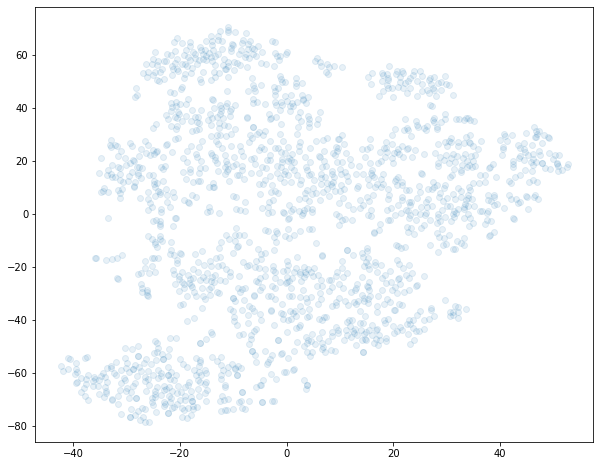

In [9]:
# The default of 1,000 iterations gives fine results, but I'm training for longer just to eke
# out some marginal improvements. NB: This takes almost an hour!
tsne = TSNE(random_state=1, n_iter=15000, metric="cosine")

embs = tsne.fit_transform(item_pmf_emb.values)
# Add to dataframe for convenience
items_df['x'] = embs[:, 0]
items_df['y'] = embs[:, 1]

FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)
fig.patch.set_facecolor("white")
# Make points translucent so we can visually identify regions with a high density of overlapping points
ax.scatter(items_df.x, items_df.y, alpha=.1)

<AxesSubplot:>

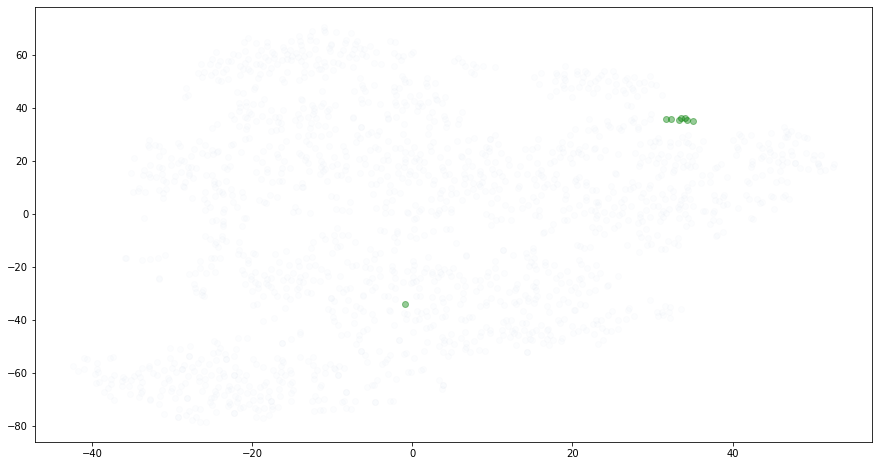

In [10]:
plot_with_annotations(items_df[items_df["item_name"].str.startswith('Star Trek')].index, text=False, alpha=.4, figsize=(15, 8))

In [11]:
single_list_similarity(items_df[items_df["item_name"].str.startswith('Star Trek')].index.values, item_pmf_emb)

0.92230266

In [12]:
users = ratings_df[ratings_df["rating"] > 3].groupby("user_id").agg({"item_id": lambda x: x.tolist()}).reset_index()
users["similarity"] = users["item_id"].apply(lambda x: single_list_similarity(x, item_pmf_emb))

In [13]:
users["similarity_norm"] = users["similarity"].apply(lambda x: (x + 1) / 2)
px.histogram(users, x="similarity_norm", title="Histogram of Similarity of User Positive Ratings")

In [14]:
users["similarity_norm"].mean()

0.8987307282769756

In [15]:
users.similarity_norm.describe()

count    942.000000
mean       0.898731
std        0.024805
min        0.839796
25%        0.880086
50%        0.892146
75%        0.912118
max        0.962499
Name: similarity_norm, dtype: float64